In [4]:
from IPython.display import display, display_html
from IPython.display import HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [6]:
def group(lst, key, value=None):
    result = defaultdict(list)
    for i in lst:
        result[key(i) if callable(key) else i[key]].append(value(i) if callable(value) else i[value] if value else i)
    return result

def scrape_cve(cve_id):
    data_ids = ["vuln-description", "vuln-cvss3-panel-score"]
    nvd_cve_url = f"https://nvd.nist.gov/vuln/detail/{cve_id}"
    cve_doc = lxml.html.fromstring(requests.get(nvd_cve_url).content)
    extracted = {id: cve_doc.xpath(f"//*[@data-testid='{id}']/text()")[0] for id in data_ids}
    return {
        "id": cve_id,
        "urls": [nvd_cve_url, microsoft_cve_url_prefix+cve_id],
        "description": extracted["vuln-description"],
        "aka": re.findall(", aka '(.*)'", extracted["vuln-description"])[0],
        "cvss_score": float(re.match("(\d+\.\d+).*", extracted["vuln-cvss3-panel-score"]).group(1))
    }

cvss_severity_colors = {
    "None": None,
    "Low": "green",
    "Medium": "#FFA53F",
    "High": "#FF4F4F",
    "Critical": "mediumorchid"  
}
cvss_severity_matrix = [
    ("None", 0.0, 0.0),
    ("Low", 0.1, 3.9),
    ("Medium", 4.0, 6.9),
    ("High", 7.0, 8.9),
    ("Critical", 9.0, 10.0)
]

def cvss_severity(score):
    for severity, from_score, to_score in cvss_severity_matrix:
        if int(from_score*10) <= int(score*10) <= int(to_score*10):
            return severity
        
def table(columns, rows):
    def table_cell_attrs(column, row=None):
        attrs = {}
        if "attrs" in column:
            for k, v in column["attrs"].items():
                if callable(v):
                    if row:
                        attrs[k] = v(row)
                else:
                     attrs[k] = v    
            if attrs:
                return " " + " ".join(f'{k}="{v}"' for k, v in attrs.items())
        return ""
    def table_header_cells():
        return [f"<th{table_cell_attrs(column)}>{column['title']}</th>" for column in columns]
    def table_body_cells(row):
        return [f"<td{table_cell_attrs(column,row)}>{column['processor'](row[column['key']]) if 'processor' in column else row[column['key']]}</td>" for column in columns]
    def table_row(cells):
        return f"<tr>{''.join(cells)}</tr>"
    return f"""<table width="100%">
    <thead>{table_row(table_header_cells())}</thead>
    <tbody>{''.join(table_row(table_body_cells(row)) for row in rows)}</tbody>
</table>"""

In [7]:
from IPython.core.display import display, HTML
import requests
from datetime import date

api_key = 'c1fc8aedfdbd46e38bc1d74df765d251'

data = requests.get(
      "https://api.msrc.microsoft.com/cvrf/{}?api-version=2016-08-01".format(date.today().strftime("%Y-%b")),
      headers={
          'api-key': api_key,
          'Accept': 'application/json'
      }).json()
display(HTML("<h1>"+data["DocumentTitle"]["Value"]+"</h1>"))
display(HTML(data["DocumentNotes"][0]["Value"]))


KB Article,Applies To
4534271,"Windows 10, version 1607, Windows Server 2016"
4534273,"Windows 10, version 1809, Windows Server version 1809, Windows 10, version 1809, Windows Server version 1809"
4534276,"Windows 10, version 1709"
4534283,Windows Server 2012 (Monthly Rollup)
4534288,Windows Server 2012 (Security-only update)
4534293,"Windows 10, version 1803, Windows Server version 1803"
4534297,"Windows 8.1, Windows Server 2012 R2 (Monthly Rollup)"
4534306,Windows 10
4534309,"Windows 8.1, Windows Server 2012 R2 (Security-only update)"


In [8]:
#<a href="(https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/.*">.+)</a>
#data["DocumentNotes"][0]["Value"]
import lxml.html
import re
from IPython.display import display, display_html
from concurrent.futures import ThreadPoolExecutor

microsoft_cve_url_prefix = "https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/"
doc = lxml.html.fromstring(data["DocumentNotes"][0]["Value"])
cve_ids = [
    i.split("/")[-1] 
    for i in 
    doc.xpath(f"//a[starts-with(@href, '{microsoft_cve_url_prefix}')]/@href")
]

with ThreadPoolExecutor(max_workers=5) as executor:
    cves = sorted(executor.map(scrape_cve, cve_ids), key=lambda x: x["cvss_score"], reverse=True)

HTML(table(
    [
        {
            "key": "id", 
            "title": "CVE", 
            "attrs": {"width": "15%"}
        },
        {
            "key": "cvss_score", 
            "title": "Severity (CVSSv3)", 
            "attrs": {"width": "5%", "bgcolor": lambda r: cvss_severity_colors[cvss_severity(r["cvss_score"])]}
        },
        {
            "key": "aka", 
            "title": "Title", 
            "attrs": {"width": "20%"}
        },
        {
            "key": "description", 
            "title": "Description"
        },
        {
            "key": "urls", 
            "title": "URL", 
            "processor": lambda urls: "<br>".join(f'<a href="{url}">{url}</a>' for url in urls)
        }
    ], 
    cves
))

CVE,Severity (CVSSv3),Title,Description,URL
CVE-2020-0609,9.8,Windows Remote Desktop Gateway (RD Gateway) Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Windows Remote Desktop Gateway (RD Gateway) when an unauthenticated attacker connects to the target system using RDP and sends specially crafted requests, aka 'Windows Remote Desktop Gateway (RD Gateway) Remote Code Execution Vulnerability'. This CVE ID is unique from CVE-2020-0610.",https://nvd.nist.gov/vuln/detail/CVE-2020-0609https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/CVE-2020-0609
CVE-2020-0610,9.8,Windows Remote Desktop Gateway (RD Gateway) Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Windows Remote Desktop Gateway (RD Gateway) when an unauthenticated attacker connects to the target system using RDP and sends specially crafted requests, aka 'Windows Remote Desktop Gateway (RD Gateway) Remote Code Execution Vulnerability'. This CVE ID is unique from CVE-2020-0609.",https://nvd.nist.gov/vuln/detail/CVE-2020-0610https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/CVE-2020-0610
CVE-2020-0654,9.1,Microsoft OneDrive for Android Security Feature Bypass Vulnerability,"A security feature bypass vulnerability exists in Microsoft OneDrive App for Android.This could allow an attacker to bypass the passcode or fingerprint requirements of the App.The security update addresses the vulnerability by correcting the way Microsoft OneDrive App for Android handles sharing links., aka 'Microsoft OneDrive for Android Security Feature Bypass Vulnerability'.",https://nvd.nist.gov/vuln/detail/CVE-2020-0654https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/CVE-2020-0654
CVE-2020-0601,8.1,Windows CryptoAPI Spoofing Vulnerability,"A spoofing vulnerability exists in the way Windows CryptoAPI (Crypt32.dll) validates Elliptic Curve Cryptography (ECC) certificates.An attacker could exploit the vulnerability by using a spoofed code-signing certificate to sign a malicious executable, making it appear the file was from a trusted, legitimate source, aka 'Windows CryptoAPI Spoofing Vulnerability'.",https://nvd.nist.gov/vuln/detail/CVE-2020-0601https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/CVE-2020-0601
CVE-2020-0650,7.8,Microsoft Excel Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Microsoft Excel software when the software fails to properly handle objects in memory, aka 'Microsoft Excel Remote Code Execution Vulnerability'. This CVE ID is unique from CVE-2020-0651, CVE-2020-0653.",https://nvd.nist.gov/vuln/detail/CVE-2020-0650https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/CVE-2020-0650
CVE-2020-0651,7.8,Microsoft Excel Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Microsoft Excel software when the software fails to properly handle objects in memory, aka 'Microsoft Excel Remote Code Execution Vulnerability'. This CVE ID is unique from CVE-2020-0650, CVE-2020-0653.",https://nvd.nist.gov/vuln/detail/CVE-2020-0651https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/CVE-2020-0651
CVE-2020-0652,7.8,Microsoft Office Memory Corruption Vulnerability,"A remote code execution vulnerability exists in Microsoft Office software when the software fails to properly handle objects in memory, aka 'Microsoft Office Memory Corruption Vulnerability'.",https://nvd.nist.gov/vuln/detail/CVE-2020-0652https://portal.msrc.microsoft.com/en-US/security-guidance/advisory/CVE-2020-0652
CVE-2020-0653,7.8,Microsoft Excel Remote Code Execution Vulnerability,"A remote code execution vulnerability exists in Microsoft Excel software when the software fails to properly handle objects in memory, aka 'Microsoft Excel Remote Code Execution Vulnerability'. This CVE ID is unique from CVE-2020-0650, CVE-2020-0651.",https://nvd.nist.gov/vuln/detail/CVE-2020-0653https://portal.msrc.microsoft.c

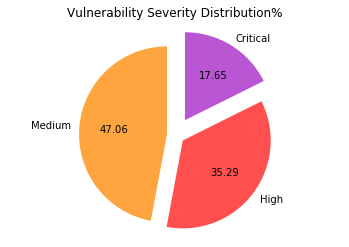

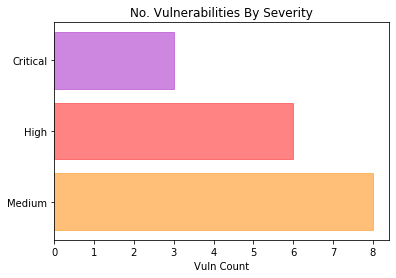

In [13]:
import matplotlib.pyplot as plotter
from collections import defaultdict

grouped_cves = group(cves, lambda x: cvss_severity(x["cvss_score"]))

severities = list([i[0] for i in cvss_severity_matrix if i[0] in grouped_cves])
severity_counts = [len(grouped_cves.get(k,[])) for k in severities]

explode_severities = {
    "None": 0.1,
    "Low": 0.1,
    "Medium": 0.1,
    "High": 0.1,
    "Critical": 0.2
}

figureObject, axesObject = plotter.subplots()
pie=axesObject.pie(severity_counts, 
        explode=[explode_severities[k] for k in severities],
        labels=severities,
        autopct='%1.2f',
        colors=[cvss_severity_colors[k] for k in severities],
        startangle=90)
axesObject.axis('equal')
plotter.title('Vulnerability Severity Distribution%')
plotter.show()

figureObject, axesObject = plotter.subplots()
barlist = axesObject.barh(severities,
        severity_counts,
        0.8,
        alpha = 0.7,
        color = 'blue',
        label = 'Vulns')
for i, s in enumerate(severities):
    barlist[i].set_color(cvss_severity_colors[s])
axesObject.set_xlabel('Vuln Count')
plotter.title('No. Vulnerabilities By Severity')
plotter.show()